In [ ]:
# https://quantum.cloud.ibm.com/docs/en/migration-guides/qiskit-1.0-features#providers.basicaer
# from qiskit import QuantumCircuit
 
# qc = QuantumCircuit(3)
# qc.h(0)
# qc.h(1)
# qc.cx(1, 2)
# qc.measure_all()
 
# # Previous
# from qiskit import BasicAer
# backend = BasicAer.get_backend("statevector_simulator")
# statevector = backend.run(qc).result().get_statevector()
 
# # Current
# qc.remove_final_measurements()  # no measurements allowed
# from qiskit.quantum_info import Statevector
# statevector = Statevector(qc)

In [ ]:
# initialization
import numpy as np
 
# Importing Qiskit
from qiskit.quantum_info import Statevector
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
 
# -------------------------------------------------------
# Deutsch-Jozsa Oracle
# -------------------------------------------------------
def dj_oracle(case, n):
    oracle_qc = QuantumCircuit(n+1)
 
    if case == "balanced":
        # Apply controlled-NOT gates for each input qubit
        for qubit in range(n):
            oracle_qc.cx(qubit, n)
 
    elif case == "constant":
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)
 
    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = "Oracle"
    return oracle_gate
 
# -------------------------------------------------------
# Deutsch-Jozsa Algorithm
# -------------------------------------------------------
def dj_algorithm(n, case='random'):
    dj_circuit = QuantumCircuit(n+1, n)
 
    # Input qubits in superposition
    for qubit in range(n):
        dj_circuit.h(qubit)
 
    # Output qubit in |-> state
    dj_circuit.x(n)
    dj_circuit.h(n)
 
    # Choose random oracle if not specified
    if case == "random":
        case = "constant" if np.random.randint(2) == 0 else "balanced"
 
    # Append oracle
    oracle = dj_oracle(case, n)
    dj_circuit.append(oracle, range(n+1))
 
    # Apply Hadamards and measure input qubits
    for i in range(n):
        dj_circuit.h(i)
        dj_circuit.measure(i, i) # link to the classical register
 
    return dj_circuit
 
# -------------------------------------------------------
# Run on Local Simulator
# -------------------------------------------------------
n = 4
dj_circuit = dj_algorithm(n, 'constant')
 
simulator = AerSimulator()
compiled = transpile(dj_circuit, simulator)
result = simulator.run(compiled, shots=1024).result()
answer = result.get_counts()
 
print("Simulation Result (local):", answer)
plot_histogram(answer)


In [ ]:
dj_circuit_balanced = dj_algorithm(n, 'balanced')

compiled_bal = transpile(dj_circuit_balanced, simulator)
result_bal = simulator.run(compiled_bal, shots=1024).result()
answer_bal = result_bal.get_counts()

print("Simulation Result (Balanced Oracle):", answer_bal)
plot_histogram(answer_bal)


https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/deutsch-jozsa.ipynb

# Constant Oracle

Let's start by creating a constant oracle, in this case the input has no effect on the output so we just randomly set the output qubit to be 0 or 1:

In [ ]:
# Initialization
import numpy as np

# importing Qiskit
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService

# import basic plot tools
from qiskit.visualization import plot_histogram

# set the length of the n-bit input string
n = 3

constant_oracle = QuantumCircuit(n+1)

output = np.random.randint(2)
print(f"Output = {output}")
if output == 1:
    constant_oracle.x(n)

constant_oracle.draw(output='mpl')

# Balanced Oracle

For n = 3 qubits, $2^3 = 8$ possible inputs: 000, 001, ..., 111.

1 extra bit $(n + 1)$, (often called the output bit or ancilla qubit) stores the result of the oracle $f(x)$.

So, the first n qubits = input register (holds the possible inputs).

The last 1 qubit = output qubit (holds $f(x)$ result).

In [ ]:
balanced_oracle = QuantumCircuit(n+1)

Next, we create a balanced oracle. As we saw in section 1b, we can create a balanced oracle by performing CNOTs with each input qubit as a control and the output bit as the target. We can vary the input states that give 0 or 1 by wrapping some of the controls in X-gates. Let's first choose a binary string of length n that dicdates which controls to wrap.

In [ ]:
b_str = "101"

Now we have this string, we can use it as a key to place our X-gates. For each qubit in our circuit, we place an X-gate if the corresponding digit in b_str is 1, or do nothing if the digit is 0.

In [ ]:
balanced_oracle = QuantumCircuit(n+1)
b_str = "101"

# Place X-gates
for qubit in range(len(b_str)):
    if b_str[qubit] == "1":
        balanced_oracle.x(qubit)

balanced_oracle.draw(output='mpl')

We do our controlled-NOT gates, using each input qubit as a control, and the output qubit as a target.

In [ ]:
balanced_oracle = QuantumCircuit(n+1)
b_str = "101"

# Place X-gates
for qubit in range(len(b_str)):
    if b_str[qubit] == "1":
        balanced_oracle.x(qubit) # flip the qubit

# Use barrier as divider
balanced_oracle.barrier()

# Controlled-NOT gates
for qubit in range(n):
    balanced_oracle.cx(qubit, n)

balanced_oracle.barrier()
balanced_oracle.draw(output='mpl')

Finally, we repeat the code from the two cells up to finish wrapping the controls in X-gates.

In [ ]:
balanced_oracle = QuantumCircuit(n+1)
b_str = "101"

# Place X-gates
for qubit in range(len(b_str)):
    if b_str[qubit] == "1":
        balanced_oracle.x(qubit)

# Use barrier as divider
balanced_oracle.barrier()

# Controlled-NOT gates
for qubit in range(n):
    balanced_oracle.cx(qubit, n)

balanced_oracle.barrier()

# Place X-gates
for qubit in range(len(b_str)):
    if b_str[qubit] == "1":
        balanced_oracle.x(qubit)

# Show oracle
balanced_oracle.draw(output='mpl')

We have just created a balanced oracle! All that's left to do is see if the Deutsch-Jozsa algorithm can solve it. 

# The Full Algorithm

Let's now put everything together. This first step in the algorithm is to initialize the input qubits in the state $|{+}\rangle$ and the output qubit in the state $|{-}\rangle$:

$|{+}\rangle = \frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)$

$|{-}\rangle = \frac{1}{\sqrt{2}}(|0\rangle - |1\rangle)$

In [ ]:
# (num_qubits, num_classical_bits)
# For n+1 qubits:
#### First n qubits = input register - we create a superposition of all possible inputs
#### Last 1 qubit = output qubit - stores f(x) (the oracle's output)
# n classical bits
#### After the algorithm, we measure the n input qubits into n classical bits.
#### We don't measure the output qubit becasue it is not needed to determine whether f(x) is constant or balanced.
dj_circuit = QuantumCircuit(n+1, n) 

# Apply H-gates
for qubit in range(n):
    dj_circuit.h(qubit)

# Put qubit in state |->
dj_circuit.x(n)
dj_circuit.h(n)
dj_circuit.draw(output='mpl')

Next, let's apply the oracle. Here we apply the balanced_oracle we created above:

In [ ]:
dj_circuit = QuantumCircuit(n+1, n)

# Apply H-gates
for qubit in range(n):
    dj_circuit.h(qubit)

# Put qubit in state |->
dj_circuit.x(n)
dj_circuit.h(n)

# Add oracle
dj_circuit = dj_circuit.compose(balanced_oracle)
dj_circuit.draw(output='mpl')

Finally, we perform H-gates on the n-input qubits, and measure our input register:

In [ ]:
dj_circuit = QuantumCircuit(n+1, n)

# Apply H-gates
for qubit in range(n):
    dj_circuit.h(qubit)

# Put qubit in state |->
dj_circuit.x(n)
dj_circuit.h(n)

# balanced_oracle
balanced_oracle = QuantumCircuit(n+1)
b_str = "101"

# Place X-gates
for qubit in range(len(b_str)):
    if b_str[qubit] == "1":
        balanced_oracle.x(qubit)

# Use barrier as divider
balanced_oracle.barrier()

# Controlled-NOT gates
for qubit in range(n):
    balanced_oracle.cx(qubit, n)

# Use barrier as divider
balanced_oracle.barrier()

# Add oracle
dj_circuit = dj_circuit.compose(balanced_oracle)

# Repeat H-gates
for qubit in range(n):
    dj_circuit.h(qubit)


# Use barrier as divider
dj_circuit.barrier()

# Measure 
for i in range(n):
    dj_circuit.measure(i, i)

# Display circuit
dj_circuit.draw(output='mpl')

Let's see the output.

In [ ]:
# Use local simulator
aer_sim = AerSimulator()


# Transpile the circuit for the simulator
compiled_circuit = transpile(dj_circuit, aer_sim)

# Run the circuit
result = aer_sim.run(compiled_circuit, shots=1024).result()
answer = result.get_counts()

# Display the resutls
print("Circuit output:", answer)
plot_histogram(answer)

In [ ]:
# ... we have a 0% chance of measuring 000.
# No error means correct
assert answer.get('000', 0) == 0

We can see from the results above that we have a 0% chance of measuring 000. 
This correclty predicts the function is balanced.

# Generalized Circuits

Below, we provide a generalized function that creates Deutsch-Jozsa oracles and turns them into quantum gates. It takes the case. (either 'balanced' or 'constant'), and n, the size of the input register.

In [1]:
# initialization
import numpy as np
 
# Importing Qiskit
from qiskit.quantum_info import Statevector
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram

In [2]:
def dj_oracle(case, n):
    # We need to make a QuantumCircuit object to return
    # This circuit has n+1 qubits: the size of the input plus one output qubit
    oracle_qc = QuantumCircuit(n+1)

    # First, let's deal with the case in which oracle is balanced
    if case == "balanced":
        # First generate a random number that tells us which CNOTs to
        # wrap in X-gates:
        b = np.random.randint(1, 2**n)
        # Next, format 'b' as a binary string of length 'n', padded with zeros:
        b_str = format(b, '0'+str(n)+'b')
        # Next, we place the first X-fates. Each digit in our binary string
        # corresponds to a qubit, if the digit is 0, we do nothing, if it is 1
        # we apply an X-gate to that qubit:
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
        # Do the controlled-NOT gates for each qubit, using the output qubit
        # as the target:
        for qubit in range(n):
            oracle_qc.cx(qubit, n)
        # Next, pace the final X-gates
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)

    # Case in which oracle is constant
    if case == "constant":
        # First decide what the fixed output of the oracle will be
        # (either always 0 or always 1)
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)

    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = "Oracle" # To show when we display the circuit
    return oracle_gate

Let's also create a function that takes this oracle gate and performs the Deutsch-Jozsa algorithm on it:

In [3]:
def dj_algorithm(oracle, n):
    dj_circuit = QuantumCircuit(n+1, n)
    # Set up the output qubit:
    dj_circuit.x(n)
    dj_circuit.h(n)
    # And set up the input register:
    for qubit in range(n):
        dj_circuit.h(qubit)
    # Let's append the oracle gate to our circuit:
    dj_circuit.append(oracle, range(n+1))
    # Finally, perform the H-gates again and measure:
    for qubit in range(n):
        dj_circuit.h(qubit)
    for i in range(n):
        dj_circuit.measure(i, i)
    return dj_circuit

Finally, let's use these functions to play around with the algorithm.

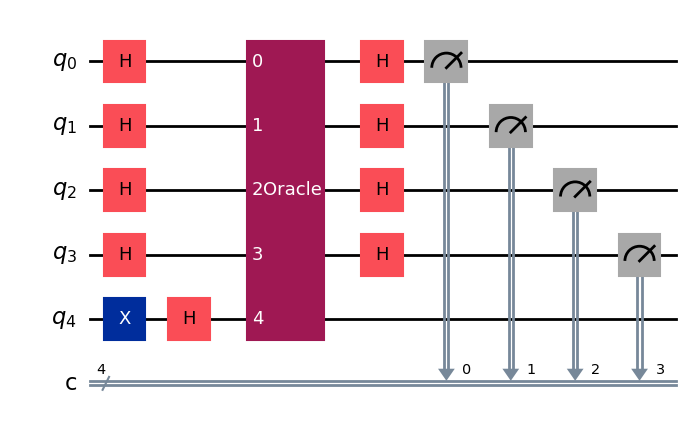

In [4]:
n = 4 
oracle_gate = dj_oracle('balanced', n)
dj_circuit = dj_algorithm(oracle_gate, n)
dj_circuit.draw(output="mpl")

Answser the results of running this circuit:

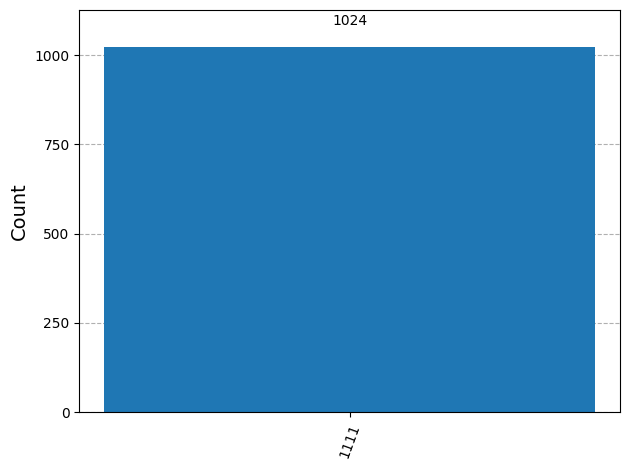

In [5]:
from qiskit_aer import AerSimulator

# Use local simulator
aer_sim = AerSimulator()

# Transpile the circuit for the simulator
compiled_circuit = transpile(dj_circuit, aer_sim)

# Run the circuit
result = aer_sim.run(compiled_circuit).result()
answer = result.get_counts()

plot_histogram(answer)

# Step by step through Deutsch-Josza (DJ) code

### Step 0: Understanding the goal

The Deutsch-Jozsa algorithm is designed to determine whether a given function $f: \{0, 1\}^n \rarr \{0, 1\}$ is constant (same output for all inputs) or balanced (half 0s, half 1s) with a single query, exploiting quantum superposition and interference.

In [1]:
# initialization
import numpy as np
 
# Importing Qiskit
from qiskit.quantum_info import Statevector
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram

### Step 1: Oracle Creation (dj_oracle)

In [2]:
n = 4
oracle_qc = QuantumCircuit(n+1)

- Create a quantum circuit for the oracle with $n$ input qubits and 1 output qubit ($n+1$ total).
- Why? The output qubit will store the result $f(x)$  in a reversible way, which is requried in quantum computing.

### Step 1a: Balanced oracle case

In [3]:
b = np.random.randint(1, 2**n)
print(f"b = {b}")
b_str = format(b, '0'+str(n)+'b')
b_str

b = 1


'0001'

- We pick a random balanced function by generating a binary string `b_str`.
- Each `1` in the string will tell us which qubits to flip (X-gate) before and after the CNOTs.
- Why? This ensures the oracle is balanced but keeps it reversible.

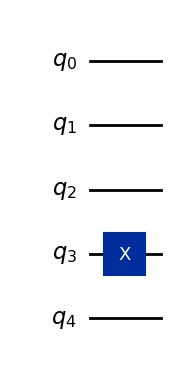

In [4]:
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        oracle_qc.x(qubit)

oracle_qc.draw(output='mpl')

- Apply X-gates to certain input qubits based on `b_str`.
- Why? This changes the input so that when we do the CNOT, we control which inputs affect the output. 

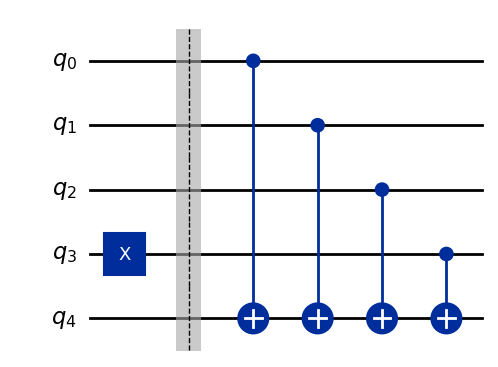

In [5]:
oracle_qc.barrier()

for qubit in range(n):
    oracle_qc.cx(qubit, n)

oracle_qc.draw(output='mpl')

- Apply CNOT gates from each input qubit to the output qubit.
- Why? This encodes $f(x)$ into the output qubit in a reversible manner. 

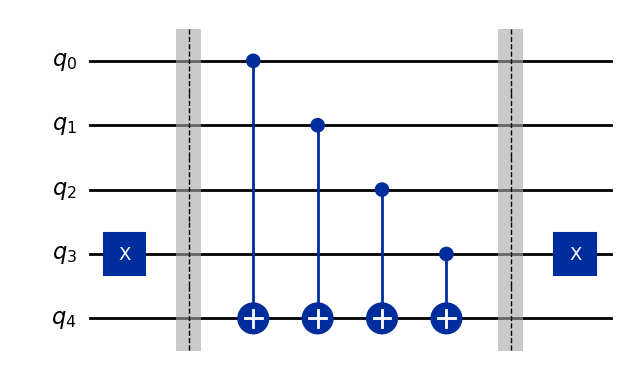

In [6]:
oracle_qc.barrier()

for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        oracle_qc.x(qubit)

oracle_qc.draw(output='mpl')

- Apply the X-gates again to restore original qubit states.
- Why? Quantum operations must be unitary and reversible, so we undo the initial flips to avoid distrubing the superposition. 

### Step 1b: Constant oracle case

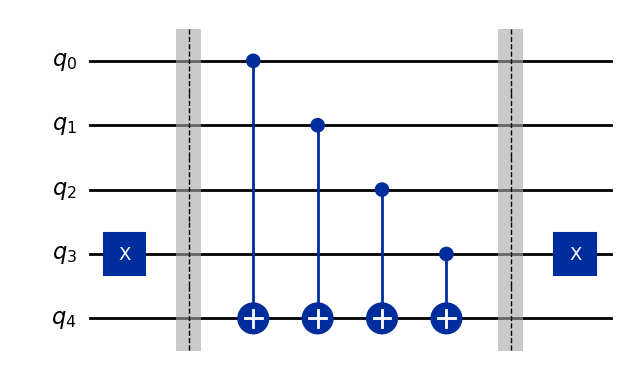

In [7]:
output = np.random.randint(2)
if output == 1:
    oracle_qc.x(n)

oracle_qc.draw(output='mpl')

- If the function is constant, the output qubit is set to always 0 or always 1.
- Why? This ensures the oracle does not depend on inputs, consistent with the constant case.

In [8]:
# To get detialed information about the circuit
print("Circuit depth:", oracle_qc.depth())
print("Number of qubits:", oracle_qc.num_qubits)
print("Operations:", oracle_qc.count_ops())

Circuit depth: 6
Number of qubits: 5
Operations: OrderedDict({'cx': 4, 'x': 2, 'barrier': 2})


### Step1c: Convert to a gate

In [9]:
### does not work with barrier()

# oracle_gate = oracle_qc.to_gate()
# oracle_gate.name = "Oracle"

# display_oracle_circuit = QuantumCircuit(n+1)
# display_oracle_circuit.append(oracle_gate, range(n+1))
# display_oracle_circuit.draw(output="mpl")

Original circuit with barriers:

Oracle gate without barriers:


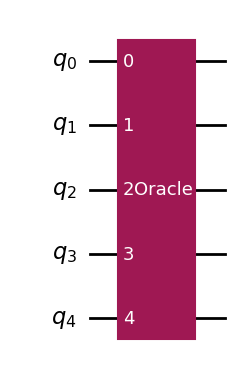

In [10]:
def create_oracle_without_barriers(circuit):
    """Remove barriers from a quantum circuit while preserving operations"""
    n = circuit.num_qubits
    new_circuit = QuantumCircuit(n)
    
    # Copy only non-barrier operations
    for instruction in circuit.data:
        if instruction.operation.name != 'barrier':
            new_circuit.append(instruction.operation, instruction.qubits)
    
    return new_circuit

# Example usage:
balanced_oracle = QuantumCircuit(n+1)
b_str = "101"

# Place X-gates
for qubit in range(len(b_str)):
    if b_str[qubit] == "1":
        balanced_oracle.x(qubit)

balanced_oracle.barrier()  # These barriers are fine for visualization

# Controlled-NOT gates
for qubit in range(n):
    balanced_oracle.cx(qubit, n)

balanced_oracle.barrier()  # These barriers are fine for visualization

# Place X-gates again
for qubit in range(len(b_str)):
    if b_str[qubit] == "1":
        balanced_oracle.x(qubit)

# Remove barriers before converting to gate
clean_oracle = create_oracle_without_barriers(balanced_oracle)
oracle_gate = clean_oracle.to_gate()
oracle_gate.name = "Oracle"

# Visualize the original circuit with barriers
print("Original circuit with barriers:")
balanced_oracle.draw(output='mpl')

# Visualize the gate
display_circuit = QuantumCircuit(n+1)
display_circuit.append(oracle_gate, range(n+1))
print("\nOracle gate without barriers:")
display_circuit.draw(output='mpl')

- Convert the oracle circuit into a single gate for easy reuse.
- Why? The DJ algorithm needs the oracle as a unitary operator operator applied in superposition. 

### Step 2: Deutsch-Jozsa Algorithm (dj_algorithm)

In [11]:
dj_circuit = QuantumCircuit(n+1, n)

- Create the DJ circuit with `n` input qubits + 1 output qubit, and `n` classical bits to store results.

### Step2a: Initialize output qubit

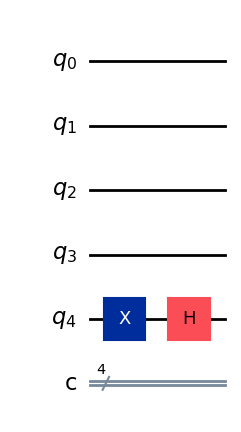

In [12]:
dj_circuit.x(n)
dj_circuit.h(n)

dj_circuit.draw(output='mpl')

- Apply X followed by Hadamard (H) to the output qubit. 
- Why? Prepares the output qubit in $|{-}\rangle {=} (|0\rangle-|1\rangle)/\sqrt{2}$
- This is necessary becasue the oracle will flip the phase depending on $f(x)$ rather than changing the computational basis.

In [13]:
# Get the state vector 
state = Statevector(dj_circuit)

# Print binary representation
print(f"Statevector in binary basis: {state}")

Statevector in binary basis: Statevector([ 0.70710678+0.j,  0.        +0.j,  0.        +0.j,
              0.        +0.j,  0.        +0.j,  0.        +0.j,
              0.        +0.j,  0.        +0.j,  0.        +0.j,
              0.        +0.j,  0.        +0.j,  0.        +0.j,
              0.        +0.j,  0.        +0.j,  0.        +0.j,
              0.        +0.j, -0.70710678+0.j,  0.        +0.j,
              0.        +0.j,  0.        +0.j,  0.        +0.j,
              0.        +0.j,  0.        +0.j,  0.        +0.j,
              0.        +0.j,  0.        +0.j,  0.        +0.j,
              0.        +0.j,  0.        +0.j,  0.        +0.j,
              0.        +0.j,  0.        +0.j],
            dims=(2, 2, 2, 2, 2))


### Step 2b: Initialize input qubits

In [14]:
for qubit in range(n):
    dj_circuit.h(qubit)

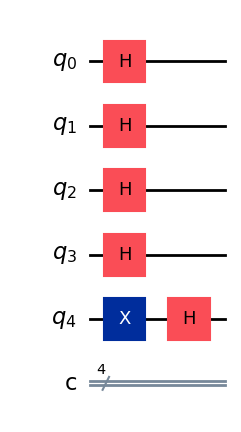

In [15]:
dj_circuit.draw(output='mpl')

- Apply Hadamard gates to all input qubits.
- Why? Create a superposition of all possible inputs $|x\rangle$, allowing us to evaluate $f(x)$ on all inputs simultaneoulsy (quantum parallelism).

In [16]:
state = Statevector(dj_circuit)

print(f"Statevector in binary basis: {state}")

Statevector in binary basis: Statevector([ 0.1767767+0.j,  0.1767767+0.j,  0.1767767+0.j,
              0.1767767+0.j,  0.1767767+0.j,  0.1767767+0.j,
              0.1767767+0.j,  0.1767767+0.j,  0.1767767+0.j,
              0.1767767+0.j,  0.1767767+0.j,  0.1767767+0.j,
              0.1767767+0.j,  0.1767767+0.j,  0.1767767+0.j,
              0.1767767+0.j, -0.1767767+0.j, -0.1767767+0.j,
             -0.1767767+0.j, -0.1767767+0.j, -0.1767767+0.j,
             -0.1767767+0.j, -0.1767767+0.j, -0.1767767+0.j,
             -0.1767767+0.j, -0.1767767+0.j, -0.1767767+0.j,
             -0.1767767+0.j, -0.1767767+0.j, -0.1767767+0.j,
             -0.1767767+0.j, -0.1767767+0.j],
            dims=(2, 2, 2, 2, 2))


### Step 2c: Apply the oracle

In [17]:
dj_circuit.append(oracle_gate, range(n+1))

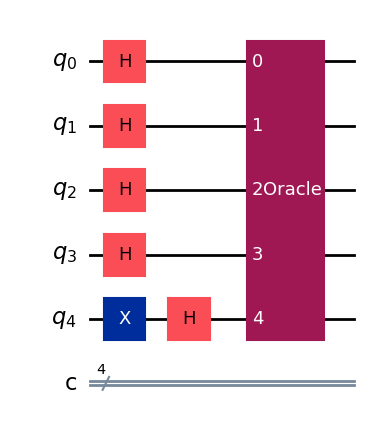

In [18]:
dj_circuit.draw(output='mpl')

- Apply the oracle gate to the circuit.
- Why? This step encodes the function $f(x)$ into the phase of the superposition using the output qubit.

In [19]:
state = Statevector(dj_circuit)

print(f"Statevector in binary basis: {state}")

Statevector in binary basis: Statevector([ 0.1767767+0.j, -0.1767767+0.j, -0.1767767+0.j,
              0.1767767+0.j, -0.1767767+0.j,  0.1767767+0.j,
              0.1767767+0.j, -0.1767767+0.j, -0.1767767+0.j,
              0.1767767+0.j,  0.1767767+0.j, -0.1767767+0.j,
              0.1767767+0.j, -0.1767767+0.j, -0.1767767+0.j,
              0.1767767+0.j, -0.1767767+0.j,  0.1767767+0.j,
              0.1767767+0.j, -0.1767767+0.j,  0.1767767+0.j,
             -0.1767767+0.j, -0.1767767+0.j,  0.1767767+0.j,
              0.1767767+0.j, -0.1767767+0.j, -0.1767767+0.j,
              0.1767767+0.j, -0.1767767+0.j,  0.1767767+0.j,
              0.1767767+0.j, -0.1767767+0.j],
            dims=(2, 2, 2, 2, 2))


### Step 2d: Interference

In [20]:
for qubit in range(n):
    dj_circuit.h(qubit)

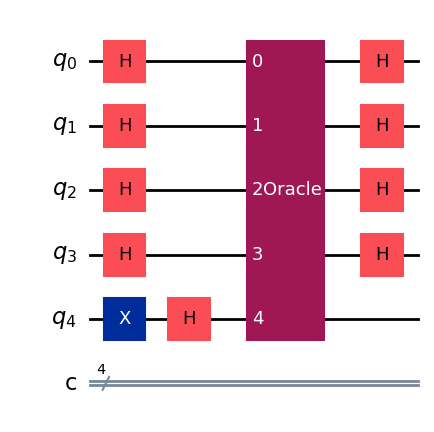

In [21]:
dj_circuit.draw(output='mpl')

- Apply Hadamard gates again to input qubits.
- Why? This performs quantum interference, which causes:
    - All amplitudes to cancel (sum to 0) if function is balanced.
    - All amplitudes to reinforce (sum to 1) if function is constant.
- This is the key quantum trich that lets DJ decide with a single oracle call.

In [22]:
state = Statevector(dj_circuit)

print(f"Statevector in binary basis: {state}")

Statevector in binary basis: Statevector([-8.03696306e-68+0.j, -9.89746461e-51+0.j,  1.25211142e-51+0.j,
              1.78038433e-34+0.j,  9.30361298e-52+0.j,  1.70104734e-34+0.j,
              1.98240910e-34+0.j,  1.34692639e-17+0.j, -2.88786304e-50+0.j,
             -2.44064821e-34+0.j, -2.58608688e-34+0.j, -6.29457921e-18+0.j,
              6.49514367e-34+0.j, -9.52420783e-18+0.j,  1.66988925e-17+0.j,
              7.07106781e-01+0.j,  8.03696306e-68+0.j,  9.89746461e-51+0.j,
             -1.25211142e-51+0.j, -1.78038433e-34+0.j, -9.30361298e-52+0.j,
             -1.70104734e-34+0.j, -1.98240910e-34+0.j, -1.34692639e-17+0.j,
              2.88786304e-50+0.j,  2.44064821e-34+0.j,  2.58608688e-34+0.j,
              6.29457921e-18+0.j, -6.49514367e-34+0.j,  9.52420783e-18+0.j,
             -1.66988925e-17+0.j, -7.07106781e-01+0.j],
            dims=(2, 2, 2, 2, 2))
